# Getting Started

In [15]:
''' Required for Google Colab'''

# Mount GDrive
# from google.colab import drive
# drive.mount('/content/drive')

# # Upload Kaggle json

# !pip install -q kaggle
# !pip install -q kaggle-cli
# !mkdir -p ~/.kaggle
# !cp "/content/drive/My Drive/Kaggle/kaggle.json" ~/.kaggle/
# !cat ~/.kaggle/kaggle.json 
# !chmod 600 ~/.kaggle/kaggle.json
# !kaggle competitions download -c fake-news -p dataset
# !unzip /content/dataset/train.csv.zip
# !unzip /content/dataset/test.csv.zip

In [ ]:
''' Required for Google Colab'''
# !pip install contractions

In [16]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import rcParams
plt.rcParams['figure.figsize'] = [10,10]
import seaborn as sns
sns.set_theme(style="darkgrid")

import nltk
from nltk import sent_tokenize
''' Required for Google Colab'''
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('stopwords')
''' Required for Google Colab'''
from nltk.corpus import stopwords
stopwords = nltk.corpus.stopwords.words('english')
from nltk.tokenize import word_tokenize
import contractions

import string
import joblib
import re

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

In [ ]:
''' Required for Google Colab'''
# train_df = pd.read_csv('/content/train.csv', header=0)
# test_df = pd.read_csv('/content/test.csv', header=0)

In [17]:
train_df = pd.read_csv('fake-news/train.csv', header=0)
test_df = pd.read_csv('fake-news/test.csv', header=0)

In [18]:
train_df = train_df.fillna(' ')
test_df = test_df.fillna(' ')

train_df['text'] = train_df['text'].str.strip()
test_df['text'] = test_df['text'].str.strip()

train_df['raw_text_length'] = train_df['text'].apply(lambda x: len(x))
print(len(train_df[train_df['raw_text_length']==0]))

116


In [19]:
train_df = train_df[train_df['raw_text_length'] > 0]
train_df.shape

(20684, 6)

## Text Cleaning

1. Remove special characters
2. Expand contractions
3. Convert to lower-case
4. Word Tokenize
5. Remove Stopwords

In [20]:
def preprocess_text(x):
    cleaned_text = re.sub(r'[^a-zA-Z\d\s\']+', '', x)
    word_list = []
    for each_word in cleaned_text.split(' '):
        try:
            word_list.append(contractions.fix(each_word).lower())
        except:
            print(x)
    return " ".join(word_list)

## Got Error because of some sort of Turkish/Slavic language
ABÇin ilişkilerinde ABD ve NATOnun etkisi yazan Manlio Dinucci Uluslararası bir forumda konuşan İtalyan coğrafyacı Manlio Dinucci ABDnin tüm dünyaya egemen olabilmek için sahip olduğu silahların analizini bireşimleştirdi Suriye Rusya ve Çinin bugün elde silah herkesin açıkça kabul ettiği bu üstünlüğü dünyanın bu tek kutuplu örgütlenişi tartışılır hale getirmesinden dolayı bu makale daha da önem kazanmaktadır


Therefore I rearranged the order of preprocessing


In [21]:
text_cols = ['text', 'title', 'author']

In [22]:
%%time
for col in text_cols:
    print("Processing column: {}".format(col))
    train_df[col] = train_df[col].apply(lambda x: preprocess_text(x))
    test_df[col] = test_df[col].apply(lambda x: preprocess_text(x))

Processing column: text
Processing column: title
Processing column: author
Wall time: 1min 5s


In [23]:
%%time
for col in text_cols:
    print("Processing column: {}".format(col))
    train_df[col] = train_df[col].apply(word_tokenize)
    test_df[col] = test_df[col].apply(word_tokenize)

Processing column: text
Processing column: title
Processing column: author
Wall time: 1min 9s


In [24]:
%%time
for col in text_cols:
    print("Processing column: {}".format(col))
    train_df[col] = train_df[col].apply(
        lambda x: [each_word for each_word in x if each_word not in stopwords])
    test_df[col] = test_df[col].apply(
        lambda x: [each_word for each_word in x if each_word not in stopwords])

Processing column: text
Processing column: title
Processing column: author
Wall time: 36.8 s


In [25]:
train_df.head() 

,id,title,author,text,label,raw_text_length
0,0,"[house, dem, aide, even, see, comeys, letter, ...","[darrell, lucus]","[house, dem, aide, even, see, comeys, letter, ...",1,4930
1,1,"[flynn, hillary, clinton, big, woman, campus, ...","[daniel, j, flynn]","[ever, get, feeling, life, circles, roundabout...",0,4160
2,2,"[truth, might, get, fired]",[consortiumnewscom],"[truth, might, get, fired, october, 29, 2016, ...",1,7692
3,3,"[15, civilians, killed, single, us, airstrike,...","[jessica, purkiss]","[videos, 15, civilians, killed, single, us, ai...",1,3237
4,4,"[iranian, woman, jailed, fictional, unpublishe...","[howard, portnoy]","[print, iranian, woman, sentenced, six, years,...",1,938


## Model Training

In [13]:
train_df['text_joined'] = train_df['text'].apply(lambda x: " ".join(x))
test_df['text_joined'] = test_df['text'].apply(lambda x: " ".join(x))

target = train_df['label'].values

In [ ]:
count_vectorizer = CountVectorizer(ngram_range=(1, 2))
tf_idf_transformer = TfidfTransformer(smooth_idf=False)

# fit train data to count vectorizer
count_vectorizer.fit(train_df['text_joined'].values)
count_vect_train = count_vectorizer.transform(train_df['text_joined'].values)

# fit ngrams count to tfidf transformers
tf_idf_transformer.fit(count_vect_train)
tf_idf_train = tf_idf_transformer.transform(count_vect_train)

In [ ]:
# Transform the test data as well
count_vect_test = count_vectorizer.transform(test_df['text_joined'].values)
tf_idf_test = tf_idf_transformer.transform(count_vect_test)

# Train Test Split


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(tf_idf_train, target, random_state=0)

In [ ]:
df_perf_metrics = pd.DataFrame(columns=['Model', 'Accuracy_Training_Set', 'Accuracy_Test_Set', 'Precision', 'Recall', 'f1_score'])

# Machine Learning Classifier Training and Validating

In [ ]:
df_perf_metrics = pd.DataFrame(columns=[
    'Model', 'Accuracy_Training_Set', 'Accuracy_Test_Set', 'Precision',
    'Recall', 'f1_score', 'Training Time (secs'
])
models_trained_list = []


def get_perf_metrics(model, i):
    # model name
    model_name = type(model).__name__
    # time keeping
    start_time = time.time()
    print("Training {} model...".format(model_name))
    # Fitting of model
    model.fit(X_train, y_train)
    print("Completed {} model training.".format(model_name))
    elapsed_time = time.time() - start_time
    # Time Elapsed
    print("Time elapsed: {:.2f} s.".format(elapsed_time))
    # Predictions
    y_pred = model.predict(X_test)
    # Add to ith row of dataframe - metrics
    df_perf_metrics.loc[i] = [
        model_name,
        model.score(X_train, y_train),
        model.score(X_test, y_test),
        precision_score(y_test, y_pred),
        recall_score(y_test, y_pred),
        f1_score(y_test, y_pred), "{:.2f}".format(elapsed_time)
    ]
    # keep a track of trained models
    models_trained_list.append(model)
    print("Completed {} model's performance assessment.".format(model_name))

In [ ]:
models_list = [LogisticRegression(),
               MultinomialNB(),
               RandomForestClassifier(),
               DecisionTreeClassifier(),
               GradientBoostingClassifier(),
               AdaBoostClassifier()]

In [ ]:
%%time
for n, model in enumerate(models_list):
    get_perf_metrics(model, n)

Training LogisticRegression model...
Completed LogisticRegression model training.
Time elapsed: 54.51 s.
Completed LogisticRegression model's performance assessment.
Training MultinomialNB model...
Completed MultinomialNB model training.
Time elapsed: 0.59 s.
Completed MultinomialNB model's performance assessment.
Training RandomForestClassifier model...
Completed RandomForestClassifier model training.
Time elapsed: 897.86 s.
Completed RandomForestClassifier model's performance assessment.
Training DecisionTreeClassifier model...
Completed DecisionTreeClassifier model training.
Time elapsed: 404.55 s.
Completed DecisionTreeClassifier model's performance assessment.
Training GradientBoostingClassifier model...
Completed GradientBoostingClassifier model training.
Time elapsed: 6715.15 s.
Completed GradientBoostingClassifier model's performance assessment.
Training AdaBoostClassifier model...
Completed AdaBoostClassifier model training.
Time elapsed: 2965.27 s.
Completed AdaBoostClassifie

In [ ]:
df_perf_metrics

,Model,Accuracy_Training_Set,Accuracy_Test_Set,Precision,Recall,f1_score,Training Time (secs
0,LogisticRegression,0.982660,0.946432,0.927520,0.966562,0.946638,54.51
1,MultinomialNB,0.949333,0.844131,0.997136,0.684894,0.812034,0.59
2,RandomForestClassifier,0.999936,0.905047,0.926049,0.876869,0.900788,897.86
3,DecisionTreeClassifier,0.999936,0.903114,0.899101,0.904406,0.901745,404.55
4,GradientBoostingClassifier,0.945723,0.938697,0.924780,0.952793,0.938578,6715.15
5,AdaBoostClassifier,0.939019,0.941597,0.934109,0.948072,0.941039,2965.27


## Adding Title and Author Information to the Text

To check if there is any improvement

In [26]:
train_df['all_info'] = train_df['text'] + train_df['title'] + train_df['author']
train_df['all_info'] = train_df['all_info'].apply(lambda x: " ".join(x))

test_df['all_info'] = test_df['text'] + test_df['title'] + test_df['author']
test_df['all_info'] = test_df['all_info'].apply(lambda x: " ".join(x))

In [27]:
tf_idf_transformer = TfidfTransformer(smooth_idf=False)
count_vectorizer = CountVectorizer(ngram_range=(1, 2))
count_vect_train = count_vectorizer.fit_transform(train_df['all_info'].values)
tf_idf_train = tf_idf_transformer.fit_transform(count_vect_train)

X_train, X_test, y_train, y_test = train_test_split(tf_idf_train,
                                                    target,
                                                    random_state=0)

In [28]:
# Transform the test data
count_vect_test = count_vectorizer.transform(test_df['all_info'].values)
tf_idf_test = tf_idf_transformer.transform(count_vect_test)

In [ ]:
%%time
for n, model in enumerate(models_list):
    get_perf_metrics(model, n)

Training LogisticRegression model...
Completed LogisticRegression model training.
Time elapsed: 60.48 s.
Completed LogisticRegression model's performance assessment.
Training MultinomialNB model...
Completed MultinomialNB model training.
Time elapsed: 0.66 s.
Completed MultinomialNB model's performance assessment.
Training RandomForestClassifier model...
Completed RandomForestClassifier model training.
Time elapsed: 640.87 s.
Completed RandomForestClassifier model's performance assessment.
Training DecisionTreeClassifier model...
Completed DecisionTreeClassifier model training.
Time elapsed: 197.91 s.
Completed DecisionTreeClassifier model's performance assessment.
Training GradientBoostingClassifier model...
Completed GradientBoostingClassifier model training.
Time elapsed: 6840.46 s.
Completed GradientBoostingClassifier model's performance assessment.
Training AdaBoostClassifier model...
Completed AdaBoostClassifier model training.
Time elapsed: 3028.83 s.
Completed AdaBoostClassifie

In [ ]:
df_perf_metrics

,Model,Accuracy_Training_Set,Accuracy_Test_Set,Precision,Recall,f1_score,Training Time (secs
0,LogisticRegression,0.988075,0.961710,0.949731,0.973643,0.961538,60.48
1,MultinomialNB,0.950106,0.851479,0.998315,0.699056,0.822304,0.66
2,RandomForestClassifier,1.000000,0.927867,0.945014,0.905980,0.925085,640.87
3,DecisionTreeClassifier,1.000000,0.980275,0.980315,0.979544,0.979929,197.91
4,GradientBoostingClassifier,0.980275,0.976794,0.972309,0.980724,0.976498,6840.46
5,AdaBoostClassifier,0.975891,0.973699,0.971765,0.974823,0.973291,3028.83


## Tuning the Logistic Regression Model

In [29]:
model = LogisticRegression()

In [30]:
max_iter = [100, 200, 500, 1000]
C = [0.1, 0.5, 1, 10, 50, 100]

param_grid = dict(max_iter=max_iter, C=C)

In [31]:
grid = GridSearchCV(estimator=model,
                    param_grid=param_grid,
                    cv=5,
                    scoring=['f1'],
                    refit='f1',
                    verbose=2)

In [32]:
%%time
grid_result = grid.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END ................................C=0.1, max_iter=100; total time=  40.4s
[CV] END ................................C=0.1, max_iter=100; total time=  34.7s
[CV] END ................................C=0.1, max_iter=100; total time=  34.2s
[CV] END ................................C=0.1, max_iter=100; total time=  31.1s
[CV] END ................................C=0.1, max_iter=100; total time=  34.1s
[CV] END ................................C=0.1, max_iter=200; total time=  35.5s
[CV] END ................................C=0.1, max_iter=200; total time=  33.8s
[CV] END ................................C=0.1, max_iter=200; total time=  34.0s
[CV] END ................................C=0.1, max_iter=200; total time=  30.9s
[CV] END ................................C=0.1, max_iter=200; total time=  32.0s
[CV] END ................................C=0.1, max_iter=500; total time=  37.4s
[CV] END ................................C=0.1,

[CV] END ................................C=100, max_iter=100; total time= 1.5min
[CV] END ................................C=100, max_iter=100; total time= 1.4min
[CV] END ................................C=100, max_iter=100; total time= 1.4min
[CV] END ................................C=100, max_iter=100; total time= 1.4min
[CV] END ................................C=100, max_iter=200; total time= 2.0min
[CV] END ................................C=100, max_iter=200; total time= 2.1min
[CV] END ................................C=100, max_iter=200; total time= 2.0min
[CV] END ................................C=100, max_iter=200; total time= 1.5min
[CV] END ................................C=100, max_iter=200; total time= 2.3min
[CV] END ................................C=100, max_iter=500; total time= 2.0min
[CV] END ................................C=100, max_iter=500; total time= 2.1min
[CV] END ................................C=100, max_iter=500; total time= 1.9min
[CV] END ...................

In [33]:
grid_result.best_estimator_

LogisticRegression(C=100)

In [38]:
grid_result.best_params_

{'C': 100, 'max_iter': 100}

In [35]:
model = grid_result.best_estimator_
y_pred = model.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred))
print('Recall: ', recall_score(y_test, y_pred))
print('f1-score: ', f1_score(y_test, y_pred))

Accuracy:  0.9762134983562174
Precision:  0.9678916827852998
Recall:  0.98426435877262
f1-score:  0.976009362200117


## Retuning the Logistic Regression Classifier

### Attempt 1
In the last grid, the lowest of the max_iter list (100) and highest of the C list (100) were the best values. In this attempt, I will see if there are better fits in the values beyond these, lower than 100 for max_iter or just a bit higher, and higher than 100 for C or just a bit lower.

In [39]:
%%time
model = LogisticRegression()

max_iter = [50, 75, 100]
C = [75, 100, 125]

param_grid = dict(max_iter=max_iter, C=C)

grid = GridSearchCV(estimator=model,
                    param_grid=param_grid,
                    cv=5,
                    scoring=['f1'],
                    refit='f1',
                    verbose=2)

grid_result = grid.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END ..................................C=75, max_iter=50; total time= 2.3min
[CV] END ..................................C=75, max_iter=50; total time= 2.0min
[CV] END ..................................C=75, max_iter=50; total time= 2.1min
[CV] END ..................................C=75, max_iter=50; total time= 2.0min
[CV] END ..................................C=75, max_iter=50; total time= 2.0min
[CV] END ..................................C=75, max_iter=75; total time= 2.7min
[CV] END ..................................C=75, max_iter=75; total time= 2.9min
[CV] END ..................................C=75, max_iter=75; total time= 2.9min
[CV] END ..................................C=75, max_iter=75; total time= 2.9min
[CV] END ..................................C=75, max_iter=75; total time= 2.6min
[CV] END .................................C=75, max_iter=100; total time= 3.6min
[CV] END .................................C=75, m

In [40]:
model = grid_result.best_estimator_
y_pred = model.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred))
print('Recall: ', recall_score(y_test, y_pred))
print('f1-score: ', f1_score(y_test, y_pred))

Accuracy:  0.9764068845484433
Precision:  0.968266253869969
Recall:  0.98426435877262
f1-score:  0.9761997658993368


In [41]:
grid_result.best_params_

{'C': 125, 'max_iter': 100}

### Attempt 2

In the previous attempt, we saw max_iter is still at 100 while C = 125 resulted into a marginally higher precision and consequently the f1 score improved just a bit. Let's see if we can improve the results a little more.

For this I have kept C constant and I have stated a range of C from 120 to 150 which increases by a step value of 10.

In [42]:
%%time
model = LogisticRegression()

max_iter = [100]
C = [120, 130, 140, 150]

param_grid = dict(max_iter=max_iter, C=C)

grid = GridSearchCV(estimator=model,
                    param_grid=param_grid,
                    cv=5,
                    scoring=['f1'],
                    refit='f1',
                    verbose=2)

grid_result = grid.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END ................................C=120, max_iter=100; total time= 3.7min
[CV] END ................................C=120, max_iter=100; total time= 3.9min
[CV] END ................................C=120, max_iter=100; total time= 3.8min
[CV] END ................................C=120, max_iter=100; total time= 3.6min
[CV] END ................................C=120, max_iter=100; total time= 3.8min
[CV] END ................................C=130, max_iter=100; total time= 3.7min
[CV] END ................................C=130, max_iter=100; total time= 3.7min
[CV] END ................................C=130, max_iter=100; total time= 3.7min
[CV] END ................................C=130, max_iter=100; total time= 3.8min
[CV] END ................................C=130, max_iter=100; total time= 3.7min
[CV] END ................................C=140, max_iter=100; total time= 3.7min
[CV] END ................................C=140, m

In [43]:
model = grid_result.best_estimator_
y_pred = model.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred))
print('Recall: ', recall_score(y_test, y_pred))
print('f1-score: ', f1_score(y_test, y_pred))

Accuracy:  0.9762134983562174
Precision:  0.9678916827852998
Recall:  0.98426435877262
f1-score:  0.976009362200117


In [44]:
grid_result.best_params_

{'C': 140, 'max_iter': 100}

### Attempt 3

One final attempt to find the best model, keeping C = 100 and max_iter = 100, 125, 140.

In [46]:
%%time
model = LogisticRegression()

max_iter = [100]
C = [100, 125, 140]

param_grid = dict(max_iter=max_iter, C=C)

grid = GridSearchCV(estimator=model,
                    param_grid=param_grid,
                    cv=5,
                    scoring=['f1'],
                    refit='f1',
                    verbose=2)

grid_result = grid.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END ................................C=100, max_iter=100; total time= 1.4min
[CV] END ................................C=100, max_iter=100; total time= 1.3min
[CV] END ................................C=100, max_iter=100; total time= 1.3min
[CV] END ................................C=100, max_iter=100; total time= 1.3min
[CV] END ................................C=100, max_iter=100; total time= 1.3min
[CV] END ................................C=125, max_iter=100; total time= 1.4min
[CV] END ................................C=125, max_iter=100; total time= 1.3min
[CV] END ................................C=125, max_iter=100; total time= 1.3min
[CV] END ................................C=125, max_iter=100; total time= 1.4min
[CV] END ................................C=125, max_iter=100; total time= 1.3min
[CV] END ................................C=140, max_iter=100; total time= 1.4min
[CV] END ................................C=140, m

In [47]:
model = grid_result.best_estimator_
y_pred = model.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred))
print('Recall: ', recall_score(y_test, y_pred))
print('f1-score: ', f1_score(y_test, y_pred))

Accuracy:  0.9762134983562174
Precision:  0.9678916827852998
Recall:  0.98426435877262
f1-score:  0.976009362200117


In [48]:
grid_result.best_params_

{'C': 140, 'max_iter': 100}

In [49]:
file_name = 'Log_Reg_Best_Model.sav'
joblib.dump(model, file_name)

['Log_Reg_Best_Model.sav']

# Create Kaggle Submission

0    50.217559
1    49.782441
Name: label, dtype: float64
[51.21153846 48.78846154]


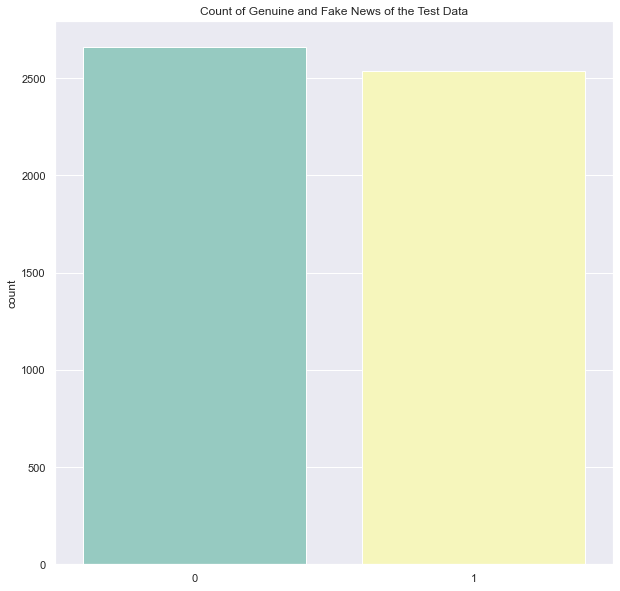

,id,label
0,20800,0
1,20801,1
2,20802,1
3,20803,0
4,20804,1


In [50]:
# Predicting the test dataframe and create submit.csv
# Picking up Logistic Regression since it has the best performance

submit_predictions = model.predict(tf_idf_test)
print(train_df['label'].value_counts() * 100/len(train_df))
print(np.bincount(submit_predictions)* 100 / len(submit_predictions))

## Create Submit Dataframe
submit_predictions_df = pd.DataFrame()
submit_predictions_df['id'] = test_df['id']
submit_predictions_df['label'] = submit_predictions

## Plot Genuine and Fake News
sns.countplot(submit_predictions, palette='Set3')
plt.title("Count of Genuine and Fake News of the Test Data")
plt.show()

submit_predictions_df.head()

In [51]:
submit_predictions_df.to_csv('kaggle_submissions/submit.csv',index=False)

Finally, uploaded my submission on Kaggle and checked the result.

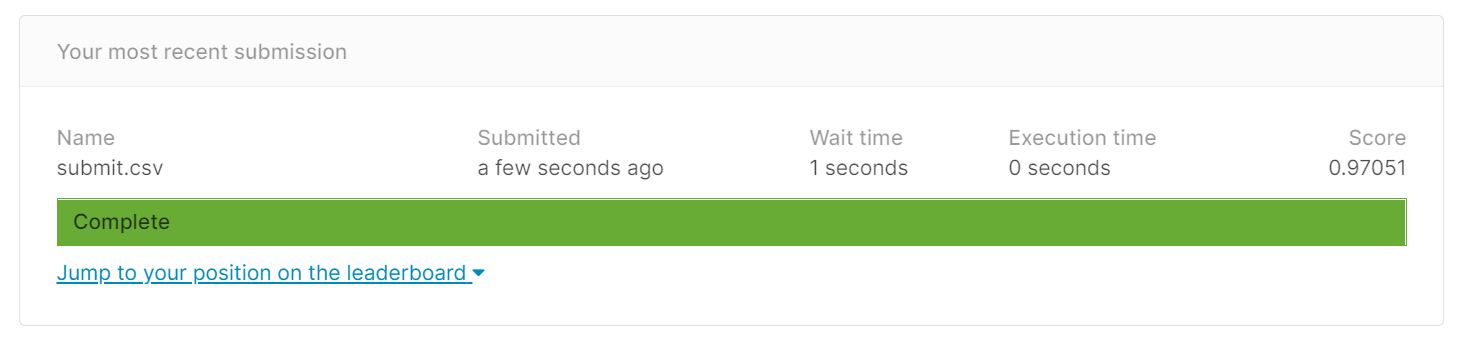

Thank you for visiting!